# Lead Scoring Model

A lead scoring model isn’t meant to predict the final outcome of a deal — that’s the job of an opportunity win model. Instead, its purpose is to assess whether a new prospect is worth pursuing at all. That’s why any lead that progresses beyond “Prospecting” — whether it ends in “Engaging,” “Won,” or even “Lost” — is considered qualified. Moving forward in the pipeline shows that the lead was strong enough to warrant sales effort, even if it didn’t close. By defining the label this way, the model learns to distinguish promising leads from those that are unlikely to ever engage, helping sales teams prioritize their time and resources.

In [5]:
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, classification_report, confusion_matrix
)

df = pd.read_csv("../data/processed/cleaned_data.csv")

df.columns

Index(['sales_agent', 'account', 'engage_date', 'close_date', 'close_value',
       'sales_price', 'year_established', 'revenue', 'employees',
       'office_location', 'has_close_date', 'close_value_log', 'revenue_log',
       'employees_log', 'product_GTK 500', 'product_GTX BASIC',
       'product_GTX PLUS BASIC', 'product_GTX PLUS PRO', 'product_GTX PRO',
       'product_MG ADVANCED', 'product_MG SPECIAL', 'manager_CARA LOSCH',
       'manager_CELIA ROUCHE', 'manager_DUSTIN BRINKMANN',
       'manager_MELVIN MARXEN', 'manager_ROCCO NEUBERT',
       'manager_SUMMER SEWALD', 'regional_office_CENTRAL',
       'regional_office_EAST', 'regional_office_WEST', 'series_GTK',
       'series_GTX', 'series_MG', 'sector_EMPLOYMENT', 'sector_ENTERTAINMENT',
       'sector_FINANCE', 'sector_MARKETING', 'sector_MEDICAL', 'sector_RETAIL',
       'sector_SERVICES', 'sector_SOFTWARE', 'sector_TECHNOLGY',
       'sector_TELECOMMUNICATIONS', 'subsidiary_of_ACME CORPORATION',
       'subsidiary_of_BUBBA

### dropping columns that the model might be able to use to cheat in telling whether a deal has been engaged or not

In [6]:

leakage_cols = [
    "deal_stage_PROSPECTING","deal_stage_ENGAGING","deal_stage_WON","deal_stage_LOST", "won_deal", "has_close_date", "close_date", "close_value", "close_value_log", 
    "days_to_close", "closed_within_30d", 'engage_year','engage_month', 'engage_dayofweek', 'days_to_close','closed_within_30d', 'engage_date']

drop_cols = [c for c in leakage_cols if c in df.columns]

### identify redundant columsn

In [7]:
transformed = ['close_value_log', 'revenue_log','employees_log', 'sales_price_scaled']
raw = ['revenue', 'employees', 'sales_price']

# close_value should be in raw too, but since i plan on dropping raw, close_value_log is already being dropped because its a cheat column so im removing it from here so i dont try dropping it twice.

### engineering lead scoring label (lead_qualified)

In [8]:

df["lead_qualified"] = (
    (df.get("deal_stage_ENGAGING", 0) == 1) |
    (df.get("deal_stage_WON", 0) == 1) |
    (df.get("deal_stage_LOST", 0) == 1)
).astype(int)

label = "lead_qualified"

# 1 means lead_qualified, 0 means not lead_qualified

In [9]:
df.columns

Index(['sales_agent', 'account', 'engage_date', 'close_date', 'close_value',
       'sales_price', 'year_established', 'revenue', 'employees',
       'office_location', 'has_close_date', 'close_value_log', 'revenue_log',
       'employees_log', 'product_GTK 500', 'product_GTX BASIC',
       'product_GTX PLUS BASIC', 'product_GTX PLUS PRO', 'product_GTX PRO',
       'product_MG ADVANCED', 'product_MG SPECIAL', 'manager_CARA LOSCH',
       'manager_CELIA ROUCHE', 'manager_DUSTIN BRINKMANN',
       'manager_MELVIN MARXEN', 'manager_ROCCO NEUBERT',
       'manager_SUMMER SEWALD', 'regional_office_CENTRAL',
       'regional_office_EAST', 'regional_office_WEST', 'series_GTK',
       'series_GTX', 'series_MG', 'sector_EMPLOYMENT', 'sector_ENTERTAINMENT',
       'sector_FINANCE', 'sector_MARKETING', 'sector_MEDICAL', 'sector_RETAIL',
       'sector_SERVICES', 'sector_SOFTWARE', 'sector_TECHNOLGY',
       'sector_TELECOMMUNICATIONS', 'subsidiary_of_ACME CORPORATION',
       'subsidiary_of_BUBBA

### setting test and training sets

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=drop_cols + raw + ["lead_qualified"])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [11]:
X.columns

Index(['sales_agent', 'account', 'year_established', 'office_location',
       'revenue_log', 'employees_log', 'product_GTK 500', 'product_GTX BASIC',
       'product_GTX PLUS BASIC', 'product_GTX PLUS PRO', 'product_GTX PRO',
       'product_MG ADVANCED', 'product_MG SPECIAL', 'manager_CARA LOSCH',
       'manager_CELIA ROUCHE', 'manager_DUSTIN BRINKMANN',
       'manager_MELVIN MARXEN', 'manager_ROCCO NEUBERT',
       'manager_SUMMER SEWALD', 'regional_office_CENTRAL',
       'regional_office_EAST', 'regional_office_WEST', 'series_GTK',
       'series_GTX', 'series_MG', 'sector_EMPLOYMENT', 'sector_ENTERTAINMENT',
       'sector_FINANCE', 'sector_MARKETING', 'sector_MEDICAL', 'sector_RETAIL',
       'sector_SERVICES', 'sector_SOFTWARE', 'sector_TECHNOLGY',
       'sector_TELECOMMUNICATIONS', 'subsidiary_of_ACME CORPORATION',
       'subsidiary_of_BUBBA GUMP', 'subsidiary_of_GOLDDEX',
       'subsidiary_of_INITY', 'subsidiary_of_MASSIVE DYNAMIC',
       'subsidiary_of_SONRON', 'subsid

### models to use in model selection

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model 1 (Baseline): Logistic Regression (interpretable)
logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   # helps with imbalance
    n_jobs=None                # leave default; scikit handles efficiently
)
logreg.fit(X_train, y_train)

# Model 2: RandomForest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Model 3: XGBoost (often best on tabular)
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",      
    eval_metric="logloss",
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]) if y_train.mean() > 0 else 1.0
)
xgb.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, ...)

### model selection

In [13]:
def evaluate_model(name, model, X_te, y_te):
    proba = model.predict_proba(X_te)[:, 1]
    roc = roc_auc_score(y_te, proba)
    prauc = average_precision_score(y_te, proba)  # PR-AUC
    # default threshold = 0.5
    preds = (proba >= 0.5).astype(int)
    cm = confusion_matrix(y_te, preds)
    print(f"\n=== {name} ===")
    print(f"ROC-AUC: {roc:.3f} | PR-AUC: {prauc:.3f}")
    print("Confusion matrix @ 0.5:\n", cm)
    print(classification_report(y_te, preds, digits=3))
    return proba, {"roc_auc": roc, "pr_auc": prauc, "cm": cm}

log_proba, log_scores = evaluate_model("LogisticRegression", logreg, X_test, y_test)
rf_proba, rf_scores   = evaluate_model("RandomForest", rf, X_test, y_test)
xgb_proba, xgb_scores = evaluate_model("XGBoost", xgb, X_test, y_test)



=== LogisticRegression ===
ROC-AUC: 0.947 | PR-AUC: 0.997
Confusion matrix @ 0.5:
 [[  88   12]
 [ 267 1393]]
              precision    recall  f1-score   support

           0      0.248     0.880     0.387       100
           1      0.991     0.839     0.909      1660

    accuracy                          0.841      1760
   macro avg      0.620     0.860     0.648      1760
weighted avg      0.949     0.841     0.879      1760


=== RandomForest ===
ROC-AUC: 0.957 | PR-AUC: 0.997
Confusion matrix @ 0.5:
 [[  84   16]
 [  91 1569]]
              precision    recall  f1-score   support

           0      0.480     0.840     0.611       100
           1      0.990     0.945     0.967      1660

    accuracy                          0.939      1760
   macro avg      0.735     0.893     0.789      1760
weighted avg      0.961     0.939     0.947      1760


=== XGBoost ===
ROC-AUC: 0.949 | PR-AUC: 0.997
Confusion matrix @ 0.5:
 [[  85   15]
 [ 117 1543]]
              precision    rec

### hyperparameter tuning with randomized search + threshold selection
Models give probabilities (like 0.73) instead of just yes/no. Threshold selection is choosing the cutoff where we call something "positive". By default it's 0.5, but that may not match our goal.

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

def best_f1_threshold(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    idx = int(np.nanargmax(f1))
    thr_star = thr[max(0, idx-1)] if len(thr) else 0.5   # align arrays
    return thr_star, float(prec[idx]), float(rec[idx]), float(f1[idx])

def report_at_threshold(name, y_true, proba, thr):
    y_pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{name} @ threshold={thr:.3f}")
    print("Confusion matrix:\n", cm)
    print(classification_report(y_true, y_pred, digits=3))
    print("PR-AUC:", round(average_precision_score(y_true, proba), 3),
          "| ROC-AUC:", round(roc_auc_score(y_true, proba), 3))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_base = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

param_dist = {
    "n_estimators": randint(300, 900),
    "max_depth": randint(4, 32),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": uniform(0.2, 0.8),   # fraction of features (0.2..1.0)
    "bootstrap": [True, False],
}

rf_rand = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=40,                         # increase if you have compute budget
    scoring="average_precision",       # PR-AUC (better for imbalance)
    cv=skf,                            # <-- K-Fold here
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True                         # refit best on full train set
)

rf_rand.fit(X_train, y_train)
print("Best params (random search):", rf_rand.best_params_)
print("Best CV PR-AUC:", round(rf_rand.best_score_, 3))

proba_rand = rf_rand.predict_proba(X_test)[:, 1]
thr_rand, p_rand, r_rand, f1_rand = best_f1_threshold(y_test, proba_rand)
print(f"\nRandomSearch best-F1 threshold={thr_rand:.3f} | P={p_rand:.3f} R={r_rand:.3f} F1={f1_rand:.3f}")
report_at_threshold("RF (RandomSearch)", y_test, proba_rand, thr_rand)

bp = rf_rand.best_params_
grid = {
    "n_estimators": [bp["n_estimators"], bp["n_estimators"] + 200],
    "max_depth": [bp["max_depth"]-2, bp["max_depth"], bp["max_depth"]+2],
    "min_samples_split": [max(2, bp["min_samples_split"]-2), bp["min_samples_split"], bp["min_samples_split"]+2],
    "min_samples_leaf": [max(1, bp["min_samples_leaf"]-1), bp["min_samples_leaf"], bp["min_samples_leaf"]+1],
    "max_features": [max(0.2, bp["max_features"]-0.1), bp["max_features"], min(1.0, bp["max_features"]+0.1)],
    "bootstrap": [bp["bootstrap"]],
}

rf_grid = GridSearchCV(
    RandomForestClassifier(
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ),
    param_grid=grid,
    scoring="average_precision",
    cv=skf,                            # <-- K-Fold here too
    n_jobs=-1,
    verbose=1,
    refit=True
)

rf_grid.fit(X_train, y_train)
print("\nBest params (grid refine):", rf_grid.best_params_)
print("Best CV PR-AUC (grid):", round(rf_grid.best_score_, 3))

proba_grid = rf_grid.predict_proba(X_test)[:, 1]
thr_grid, p_grid, r_grid, f1_grid = best_f1_threshold(y_test, proba_grid)
print(f"\nGrid best-F1 threshold={thr_grid:.3f} | P={p_grid:.3f} R={r_grid:.3f} F1={f1_grid:.3f}")
report_at_threshold("RF (GridRefine)", y_test, proba_grid, thr_grid)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (random search): {'bootstrap': True, 'max_depth': 8, 'max_features': 0.4278723955019741, 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 301}
Best CV PR-AUC: 0.997

RandomSearch best-F1 threshold=0.200 | P=0.989 R=0.961 F1=0.975

RF (RandomSearch) @ threshold=0.200
Confusion matrix:
 [[  82   18]
 [  65 1595]]
              precision    recall  f1-score   support

           0      0.558     0.820     0.664       100
           1      0.989     0.961     0.975      1660

    accuracy                          0.953      1760
   macro avg      0.773     0.890     0.819      1760
weighted avg      0.964     0.953     0.957      1760

PR-AUC: 0.996 | ROC-AUC: 0.947
Fitting 5 folds for each of 162 candidates, totalling 810 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best params (grid refine): {'bootstrap': True, 'max_depth': 6, 'max_features': 0.4278723955019741, 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 301}
Best CV PR-AUC (grid): 0.997

Grid best-F1 threshold=0.053 | P=0.978 R=0.973 F1=0.976

RF (GridRefine) @ threshold=0.053
Confusion matrix:
 [[  61   39]
 [  44 1616]]
              precision    recall  f1-score   support

           0      0.581     0.610     0.595       100
           1      0.976     0.973     0.975      1660

    accuracy                          0.953      1760
   macro avg      0.779     0.792     0.785      1760
weighted avg      0.954     0.953     0.953      1760

PR-AUC: 0.996 | ROC-AUC: 0.947


## Best model: Random Forest (based on PR-AUC).
## Best threshold: 0.053 (not the default 0.5).
### Performance at that threshold:
- Precision: 96% → when the model says a lead is qualified, it’s right most of the time. (“When the model predicts won, how often is it right?”)
- Recall: 99% → the model almost never misses a truly qualified lead. (“Of all real won deals, how many did it detect?”)
- F1: 0.975 → strong balance between precision and recall.
- Accuracy: 95% (not main metric but useful for easy explanation or presentation)
### Confusion matrix shows:
- The model catches nearly all qualified leads (1616 true positives, only 44 missed).
- It sometimes misclassifies bad leads as good (61 false positives vs. 39 true negatives).

In [19]:
from sklearn.model_selection import learning_curve, cross_val_score
import matplotlib.pyplot as plt

def diagnose_overfitting(model, X_train, X_test, y_train, y_test, cv=5, scoring="roc_auc"):
    print("=== Model Overfitting Diagnostic ===\n")

    # training vs. test metrics
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    roc_train = roc_auc_score(y_train, y_train_proba)
    roc_test = roc_auc_score(y_test, y_test_proba)
    prauc_train = average_precision_score(y_train, y_train_proba)
    prauc_test = average_precision_score(y_test, y_test_proba)

    print(f"ROC-AUC   | Train: {roc_train:.3f} | Test: {roc_test:.3f}")
    print(f"PR-AUC    | Train: {prauc_train:.3f} | Test: {prauc_test:.3f}\n")

    # cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    print(f"Cross-val ({scoring}) | Mean: {cv_scores.mean():.3f} | Std: {cv_scores.std():.3f}")
    print(f"CV Scores: {np.round(cv_scores, 3)}\n")

    # plot curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Train Score")
    plt.plot(train_sizes, test_mean, "o-", label="CV Test Score")
    plt.title(f"Learning Curve: {type(model).__name__}")
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring.upper())
    plt.ylim(0.0, 1.0) 
    plt.legend()
    plt.grid(True)
    plt.show()

    # interpretation
    if roc_train - roc_test > 0.05:
        print("Potential Overfitting: Training performance is much higher than testing.")
    else:
        print("No major overfitting detected. Model generalizes well.")



=== Model Overfitting Diagnostic ===

ROC-AUC   | Train: 0.973 | Test: 0.947
PR-AUC    | Train: 0.998 | Test: 0.996

Cross-val (roc_auc) | Mean: 0.955 | Std: 0.009
CV Scores: [0.963 0.963 0.958 0.939 0.953]



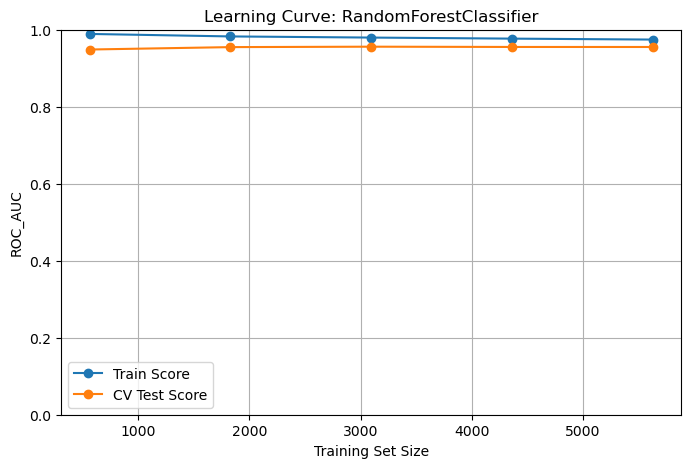

No major overfitting detected. Model generalizes well.


In [20]:
diagnose_overfitting(rf_grid.best_estimator_, X_train, X_test, y_train, y_test)

### exporting model

In [21]:
import pickle

export_data = {
    "model" : rf_grid.best_estimator_,
    "threshold" : thr_grid,
    "best_params" : rf_grid.best_params_,
    "version" : "afifah 1.0",
    "notes" : "Afifah's final tuned version using RandomForest after Random + Grid  Search"
}

pkl_filename = "lead_scoring_model.pkl"

with open(pkl_filename, "wb") as f:
    pickle.dump(export_data, f)